## 1. Import

In [26]:
# Bibliotecas principais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from core.model import ModelMetrics
from xgboost import XGBRFClassifier, XGBClassifier
from lightgbm import LGBMClassifier

from core.dataframe import Dataframe

# Salvar o modelo otimizado
import pickle

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

# # Configurações de visualização
# sns.set_style('whitegrid')
# plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load data

In [27]:
# Carregar os dados normalizados
df = Dataframe.read_csv("./datasource/train_base.csv")

# Verificar informações do dataset
print("Informações do dataset:")
print("Shape do dataset:", df.shape)

print("\nDistribuição da variável target:")
print(df['ANTECIPA'].value_counts())
print("=" * 34)
print(f"Proporção: {df['ANTECIPA'].value_counts(normalize=True)}")

# Visualizar as primeiras linhas
print("\nPrimeiras linhas:")
df.head()


Informações do dataset:
Shape do dataset: (430554, 61)

Distribuição da variável target:
shape: (2, 2)
┌──────────┬────────┐
│ ANTECIPA ┆ count  │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 24779  │
│ 0        ┆ 405775 │
└──────────┴────────┘
Proporção: shape: (2, 2)
┌──────────┬────────────┐
│ ANTECIPA ┆ proportion │
│ ---      ┆ ---        │
│ i64      ┆ f64        │
╞══════════╪════════════╡
│ 0        ┆ 0.942449   │
│ 1        ┆ 0.057551   │
└──────────┴────────────┘

Primeiras linhas:


ANTECIPA,dias_desde_ultima_antecipacao,CNPJ,dias_ate_primeira_antecipacao,TPV_CRED,QTD_TRN UNICA,dias_desde_primeiro_tpv,SALDO UNICA,UF,CIDADE,GERENTE,Região,ema7_SALDO UNICA_CNPJ,ema15_SALDO UNICA_CNPJ,ema30_SALDO UNICA_CNPJ,ema60_SALDO UNICA_CNPJ,ema90_SALDO UNICA_CNPJ,ema7_TPV_CRED_CNPJ,ema15_TPV_CRED_CNPJ,ema30_TPV_CRED_CNPJ,ema60_TPV_CRED_CNPJ,ema90_TPV_CRED_CNPJ,ema7_QTD_TRN UNICA_CNPJ,ema15_QTD_TRN UNICA_CNPJ,ema30_QTD_TRN UNICA_CNPJ,ema60_QTD_TRN UNICA_CNPJ,ema90_QTD_TRN UNICA_CNPJ,ema7_SALDO UNICA_CIDADE,ema15_SALDO UNICA_CIDADE,ema30_SALDO UNICA_CIDADE,ema60_SALDO UNICA_CIDADE,ema90_SALDO UNICA_CIDADE,ema7_TPV_CRED_CIDADE,ema15_TPV_CRED_CIDADE,ema30_TPV_CRED_CIDADE,ema60_TPV_CRED_CIDADE,ema90_TPV_CRED_CIDADE,ema7_QTD_TRN UNICA_CIDADE,ema15_QTD_TRN UNICA_CIDADE,ema30_QTD_TRN UNICA_CIDADE,ema60_QTD_TRN UNICA_CIDADE,ema90_QTD_TRN UNICA_CIDADE,ano,mes,dia,dia_semana,ema7_SALDO UNICA_dia_semana,ema15_SALDO UNICA_dia_semana,ema30_SALDO UNICA_dia_semana,ema60_SALDO UNICA_dia_semana,ema90_SALDO UNICA_dia_semana,ema7_TPV_CRED_dia_semana,ema15_TPV_CRED_dia_semana,ema30_TPV_CRED_dia_semana,ema60_TPV_CRED_dia_semana,ema90_TPV_CRED_dia_semana,ema7_QTD_TRN UNICA_dia_semana,ema15_QTD_TRN UNICA_dia_semana,ema30_QTD_TRN UNICA_dia_semana,ema60_QTD_TRN UNICA_dia_semana,ema90_QTD_TRN UNICA_dia_semana
i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,270,24940522000131,-2.0,3949.99,50,643,75074.49,0,0,0,0,75074.49,75074.49,75074.49,75074.49,75074.49,3949.99,3949.99,3949.99,3949.99,3949.99,50.0,50.0,50.0,50.0,50.0,75074.49,75074.49,75074.49,75074.49,75074.49,3949.99,3949.99,3949.99,3949.99,3949.99,50.0,50.0,50.0,50.0,50.0,2025,1,20,0,75074.49,75074.49,75074.49,75074.49,75074.49,3949.99,3949.99,3949.99,3949.99,3949.99,50.0,50.0,50.0,50.0,50.0
0,270,2795617000176,0.0,31433.2,272,1478,1.2827e6,1,1,1,0,1.2827e6,1.2827e6,1.2827e6,1.2827e6,1.2827e6,31433.2,31433.2,31433.2,31433.2,31433.2,272.0,272.0,272.0,272.0,272.0,1.2827e6,1.2827e6,1.2827e6,1.2827e6,1.2827e6,31433.2,31433.2,31433.2,31433.2,31433.2,272.0,272.0,272.0,272.0,272.0,2025,1,20,0,678904.15,678904.15,678904.15,678904.15,678904.15,17691.595,17691.595,17691.595,17691.595,17691.595,161.0,161.0,161.0,161.0,161.0
0,270,2795617000257,0.0,9875.92,107,1478,313468.28,1,1,1,0,313468.28,313468.28,313468.28,313468.28,313468.28,9875.92,9875.92,9875.92,9875.92,9875.92,107.0,107.0,107.0,107.0,107.0,798101.045,798101.045,798101.045,798101.045,798101.045,20654.56,20654.56,20654.56,20654.56,20654.56,189.5,189.5,189.5,189.5,189.5,2025,1,20,0,557092.193333,557092.193333,557092.193333,557092.193333,557092.193333,15086.37,15086.37,15086.37,15086.37,15086.37,143.0,143.0,143.0,143.0,143.0
0,270,24332670000173,0.0,9.99,1,1876,5744.37,1,2,1,0,5744.37,5744.37,5744.37,5744.37,5744.37,9.99,9.99,9.99,9.99,9.99,1.0,1.0,1.0,1.0,1.0,5744.37,5744.37,5744.37,5744.37,5744.37,9.99,9.99,9.99,9.99,9.99,1.0,1.0,1.0,1.0,1.0,2025,1,20,0,419255.2375,419255.2375,419255.2375,419255.2375,419255.2375,11317.275,11317.275,11317.275,11317.275,11317.275,107.5,107.5,107.5,107.5,107.5
0,270,7434995000148,0.0,6013.32,66,1725,281961.09,1,2,1,0,281961.09,281961.09,281961.09,281961.09,281961.09,6013.32,6013.32,6013.32,6013.32,6013.32,66.0,66.0,66.0,66.0,66.0,143852.73,143852.73,143852.73,143852.73,143852.73,3011.655,3011.655,3011.655,3011.655,3011.655,33.5,33.5,33.5,33.5,33.5,2025,1,20,0,391796.408,391796.408,391796.408,391796.408,391796.408,10256.484,10256.484,10256.484,10256.484,10256.484,99.2,99.2,99.2,99.2,99.2


In [28]:
# Separar features (X) e target (y)
features = df.drop('ANTECIPA', strict=True)
target = df['ANTECIPA']

In [29]:
from core.dataframe import Series, ArrayLike
from dataclasses import dataclass 
from typing import Literal 
import numpy as np 

@dataclass 
class DatasetPartitioner:
  features: Dataframe
  target: Series
  test_size:float=None
  train_size: float=None
  random_state: int=None
  shuffle: bool=True
  stratify: Series=None
  
  def split(self) -> list[Series]:
    X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, 
      test_size=self.test_size,
      train_size=self.train_size,
      random_state=self.random_state, 
      shuffle=self.shuffle,  
      stratify=self.target
    )
    
    return X_train, X_test, y_train, y_test
  
  def compute_weight(self, y_train: Series, class_weight: dict | Literal["balanced"] = "balanced", indices: ArrayLike | None = None):
    # Evita 'truth value of a Series is ambiguous'
    if y_train is None or len(y_train) == 0:
      return None
    y = y_train.to_numpy() if hasattr(y_train, "to_numpy") else np.asarray(y_train)
    return compute_sample_weight(class_weight=class_weight, y=y, indices=indices)

## 3. Sets (train, test)

In [30]:
# Dividir dados em treino e teste (80% treino, 20% teste)
data_splitter = DatasetPartitioner(
    features, target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

X_train, X_test, y_train, y_test = data_splitter.split()

w_train = data_splitter.compute_weight(y_train)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição no treino:\n{y_train.value_counts()}")
print(f"\nDistribuição no teste:\n{y_test.value_counts()}")

Tamanho do conjunto de treino: 344443 amostras
Tamanho do conjunto de teste: 86111 amostras

Distribuição no treino:
shape: (2, 2)
┌──────────┬────────┐
│ ANTECIPA ┆ count  │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 19823  │
│ 0        ┆ 324620 │
└──────────┴────────┘

Distribuição no teste:
shape: (2, 2)
┌──────────┬───────┐
│ ANTECIPA ┆ count │
│ ---      ┆ ---   │
│ i64      ┆ u32   │
╞══════════╪═══════╡
│ 0        ┆ 81155 │
│ 1        ┆ 4956  │
└──────────┴───────┘


## Tratar desbalanceamento: Smote

In [ ]:
# Opção 1: SMOTE (Over-sampling da classe minoritária)
#smote = SMOTE(random_state=42, k_neighbors=5)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# Opção 2: Under-sampling + Over-sampling combinados
# smote_tomek = SMOTETomek(
#   random_state=42,
#   smote=SMOTE(),
#   n_jobs=-1
# )
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


# print("Distribuição balanceada:", pd.Series(y_train).value_counts())


# Alternativa 1: LGBMClassifier

In [42]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import pandas as pd

# ratio de classes para ponto de partida
pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

# Converter para pandas DataFrame se necessário
X_train_pd = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
X_test_pd = pd.DataFrame(X_test) if not isinstance(X_test, pd.DataFrame) else X_test
y_train_pd = pd.Series(y_train) if not isinstance(y_train, pd.Series) else y_train
y_test_pd = pd.Series(y_test) if not isinstance(y_test, pd.Series) else y_test

def objective(trial: optuna.Trial):
    # Hiperparâmetros específicos do LightGBM
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [2800, 2900, 3000, 3100, 3200]),
        'max_depth': trial.suggest_int('max_depth', 7, 11),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 130, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 28, 38),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0, log=True),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [0.5*pos_weight, pos_weight, 1.5*pos_weight, 2*pos_weight]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMClassifier(**param)
    model.fit(
        X_train_pd,
        y_train_pd,
        eval_set=[(X_test_pd, y_test_pd)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
        sample_weight=w_train
    )
    
    preds = model.predict(X_test_pd)
    f1 = f1_score(y_test_pd, preds)
    return f1

# Executar a otimização
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Melhor hiperparâmetro
best_params = study.best_params
best_score = study.best_value

print("\n" + "="*50)
print("Melhores parâmetros LightGBM encontrados:")
print("="*50)
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"\nMelhor F1-Score: {best_score:.4f}")
print("="*50)

# Treinar modelo final com os melhores parâmetros
best_model = LGBMClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(
    X_train_pd,
    y_train_pd,
    eval_set=[(X_test_pd, y_test_pd)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)],
    sample_weight=w_train
)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

ModelMetrics.print_main_metrics(y_test, y_pred, y_pred_proba)
ModelMetrics.plot_precision_recall_curve(y_test, y_pred_proba)

[I 2025-10-19 21:30:12,482] A new study created in memory with name: no-name-4e2e71a9-cbec-4046-87d6-ba4258cfd428
Best trial: 0. Best value: 0.273706:   5%|▌         | 1/20 [00:10<03:16, 10.36s/it]

[I 2025-10-19 21:30:22,836] Trial 0 finished with value: 0.27370550389121456 and parameters: {'n_estimators': 3100, 'max_depth': 7, 'learning_rate': 0.040310701280916975, 'num_leaves': 150, 'min_child_samples': 33, 'subsample': 0.8001360351435503, 'colsample_bytree': 0.989777963235356, 'reg_alpha': 0.005931956638162322, 'reg_lambda': 4.5171692398763374, 'scale_pos_weight': 8.18796347676941}. Best is trial 0 with value: 0.27370550389121456.


Best trial: 1. Best value: 0.454465:  10%|█         | 2/20 [00:40<06:38, 22.14s/it]

[I 2025-10-19 21:30:53,219] Trial 1 finished with value: 0.4544653501269891 and parameters: {'n_estimators': 2900, 'max_depth': 11, 'learning_rate': 0.08394030106514463, 'num_leaves': 139, 'min_child_samples': 28, 'subsample': 0.9619375002231725, 'colsample_bytree': 0.644511745039182, 'reg_alpha': 0.005366493892175037, 'reg_lambda': 1.4392252321569496, 'scale_pos_weight': 32.75185390707764}. Best is trial 1 with value: 0.4544653501269891.


Best trial: 1. Best value: 0.454465:  15%|█▌        | 3/20 [00:49<04:36, 16.24s/it]

[I 2025-10-19 21:31:02,436] Trial 2 finished with value: 0.17468182952479414 and parameters: {'n_estimators': 2800, 'max_depth': 7, 'learning_rate': 0.01896721421290244, 'num_leaves': 145, 'min_child_samples': 34, 'subsample': 0.9302986926492844, 'colsample_bytree': 0.6185074881906745, 'reg_alpha': 0.023292839434681245, 'reg_lambda': 1.9688927303527115, 'scale_pos_weight': 24.563890430308227}. Best is trial 1 with value: 0.4544653501269891.


Best trial: 1. Best value: 0.454465:  20%|██        | 4/20 [01:07<04:27, 16.69s/it]

[I 2025-10-19 21:31:19,825] Trial 3 finished with value: 0.2796977793099486 and parameters: {'n_estimators': 3100, 'max_depth': 10, 'learning_rate': 0.019149679169300188, 'num_leaves': 146, 'min_child_samples': 30, 'subsample': 0.6884835445458579, 'colsample_bytree': 0.8397318312801582, 'reg_alpha': 0.008477710249106988, 'reg_lambda': 2.8738086530263964, 'scale_pos_weight': 8.18796347676941}. Best is trial 1 with value: 0.4544653501269891.


Best trial: 1. Best value: 0.454465:  25%|██▌       | 5/20 [01:18<03:37, 14.52s/it]

[I 2025-10-19 21:31:30,504] Trial 4 finished with value: 0.19710203668051474 and parameters: {'n_estimators': 2900, 'max_depth': 8, 'learning_rate': 0.019870882127820812, 'num_leaves': 130, 'min_child_samples': 31, 'subsample': 0.887014935280081, 'colsample_bytree': 0.630860899818922, 'reg_alpha': 0.0028100842004761344, 'reg_lambda': 0.6294733172554053, 'scale_pos_weight': 24.563890430308227}. Best is trial 1 with value: 0.4544653501269891.


Best trial: 1. Best value: 0.454465:  30%|███       | 6/20 [01:34<03:34, 15.30s/it]

[I 2025-10-19 21:31:47,315] Trial 5 finished with value: 0.24661403818507402 and parameters: {'n_estimators': 3200, 'max_depth': 11, 'learning_rate': 0.026853591146741213, 'num_leaves': 149, 'min_child_samples': 35, 'subsample': 0.5388314735098645, 'colsample_bytree': 0.9656125719630502, 'reg_alpha': 0.005860278024942943, 'reg_lambda': 4.975945193616235, 'scale_pos_weight': 32.75185390707764}. Best is trial 1 with value: 0.4544653501269891.


Best trial: 6. Best value: 0.59945:  35%|███▌      | 7/20 [03:22<09:52, 45.58s/it] 

[I 2025-10-19 21:33:35,215] Trial 6 finished with value: 0.5994498882585525 and parameters: {'n_estimators': 2800, 'max_depth': 8, 'learning_rate': 0.06573347870995418, 'num_leaves': 145, 'min_child_samples': 34, 'subsample': 0.6307945780871365, 'colsample_bytree': 0.5240945929500216, 'reg_alpha': 0.0026941711765498355, 'reg_lambda': 0.7770874948938388, 'scale_pos_weight': 8.18796347676941}. Best is trial 6 with value: 0.5994498882585525.


Best trial: 6. Best value: 0.59945:  40%|████      | 8/20 [03:43<07:30, 37.53s/it]

[I 2025-10-19 21:33:55,512] Trial 7 finished with value: 0.2602050326188257 and parameters: {'n_estimators': 3000, 'max_depth': 11, 'learning_rate': 0.013141323388722875, 'num_leaves': 132, 'min_child_samples': 38, 'subsample': 0.5448179084748774, 'colsample_bytree': 0.9954927782740429, 'reg_alpha': 0.0027590153046174824, 'reg_lambda': 3.378390222340355, 'scale_pos_weight': 16.37592695353882}. Best is trial 6 with value: 0.5994498882585525.


Best trial: 6. Best value: 0.59945:  45%|████▌     | 9/20 [03:58<05:36, 30.61s/it]

[I 2025-10-19 21:34:10,924] Trial 8 finished with value: 0.2761147401306447 and parameters: {'n_estimators': 3000, 'max_depth': 9, 'learning_rate': 0.018392990044372226, 'num_leaves': 150, 'min_child_samples': 29, 'subsample': 0.7990023947525215, 'colsample_bytree': 0.6343473016137929, 'reg_alpha': 0.014465313412308722, 'reg_lambda': 2.9984538114052253, 'scale_pos_weight': 8.18796347676941}. Best is trial 6 with value: 0.5994498882585525.


Best trial: 6. Best value: 0.59945:  50%|█████     | 10/20 [04:17<04:30, 27.09s/it]

[I 2025-10-19 21:34:30,121] Trial 9 finished with value: 0.2583068783068783 and parameters: {'n_estimators': 3200, 'max_depth': 9, 'learning_rate': 0.012593120810452387, 'num_leaves': 132, 'min_child_samples': 32, 'subsample': 0.9708061806393429, 'colsample_bytree': 0.7378247485710718, 'reg_alpha': 0.008035557856435855, 'reg_lambda': 3.8696018350174737, 'scale_pos_weight': 16.37592695353882}. Best is trial 6 with value: 0.5994498882585525.


Best trial: 6. Best value: 0.59945:  55%|█████▌    | 11/20 [04:47<04:12, 28.08s/it]

[I 2025-10-19 21:35:00,428] Trial 10 finished with value: 0.43515258215962443 and parameters: {'n_estimators': 2800, 'max_depth': 8, 'learning_rate': 0.09899344560310058, 'num_leaves': 140, 'min_child_samples': 36, 'subsample': 0.6445017520834092, 'colsample_bytree': 0.5118810426099968, 'reg_alpha': 0.001238740770161228, 'reg_lambda': 0.520143174461079, 'scale_pos_weight': 8.18796347676941}. Best is trial 6 with value: 0.5994498882585525.


Best trial: 11. Best value: 0.615104:  60%|██████    | 12/20 [06:58<07:54, 59.31s/it]

[I 2025-10-19 21:37:11,176] Trial 11 finished with value: 0.6151043090097477 and parameters: {'n_estimators': 2900, 'max_depth': 10, 'learning_rate': 0.08011362814409193, 'num_leaves': 139, 'min_child_samples': 28, 'subsample': 0.6448835650765558, 'colsample_bytree': 0.5040457615950471, 'reg_alpha': 0.055901107169381056, 'reg_lambda': 0.9750955798621678, 'scale_pos_weight': 32.75185390707764}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  65%|██████▌   | 13/20 [07:09<05:12, 44.58s/it]

[I 2025-10-19 21:37:21,854] Trial 12 finished with value: 0.14490015791726316 and parameters: {'n_estimators': 2800, 'max_depth': 9, 'learning_rate': 0.059356149770633554, 'num_leaves': 137, 'min_child_samples': 37, 'subsample': 0.6489546165630264, 'colsample_bytree': 0.5135922185094698, 'reg_alpha': 0.06240463176765055, 'reg_lambda': 1.0072745236816087, 'scale_pos_weight': 32.75185390707764}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  70%|███████   | 14/20 [09:10<06:45, 67.63s/it]

[I 2025-10-19 21:39:22,765] Trial 13 finished with value: 0.594859241126071 and parameters: {'n_estimators': 2900, 'max_depth': 10, 'learning_rate': 0.05721908671229885, 'num_leaves': 144, 'min_child_samples': 32, 'subsample': 0.5992553856446041, 'colsample_bytree': 0.5515060165108333, 'reg_alpha': 0.08647693062756903, 'reg_lambda': 0.8794398610789819, 'scale_pos_weight': 32.75185390707764}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  75%|███████▌  | 15/20 [09:58<05:08, 61.74s/it]

[I 2025-10-19 21:40:10,840] Trial 14 finished with value: 0.4608562529694346 and parameters: {'n_estimators': 2800, 'max_depth': 8, 'learning_rate': 0.0651737224023989, 'num_leaves': 136, 'min_child_samples': 34, 'subsample': 0.7175946733083011, 'colsample_bytree': 0.7437455175489134, 'reg_alpha': 0.03313881454819867, 'reg_lambda': 0.9381061673454226, 'scale_pos_weight': 8.18796347676941}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  80%|████████  | 16/20 [10:09<03:05, 46.46s/it]

[I 2025-10-19 21:40:21,831] Trial 15 finished with value: 0.21238201607428334 and parameters: {'n_estimators': 2900, 'max_depth': 10, 'learning_rate': 0.041567138428854435, 'num_leaves': 142, 'min_child_samples': 28, 'subsample': 0.5030014962323983, 'colsample_bytree': 0.5777172252277217, 'reg_alpha': 0.0011910460235225527, 'reg_lambda': 1.3777617790209533, 'scale_pos_weight': 32.75185390707764}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  85%|████████▌ | 17/20 [10:39<02:04, 41.53s/it]

[I 2025-10-19 21:40:51,882] Trial 16 finished with value: 0.393444037092948 and parameters: {'n_estimators': 2800, 'max_depth': 8, 'learning_rate': 0.07572922557091626, 'num_leaves': 142, 'min_child_samples': 30, 'subsample': 0.5987324337633617, 'colsample_bytree': 0.699761723144194, 'reg_alpha': 0.0028128209770980975, 'reg_lambda': 0.7184101932096657, 'scale_pos_weight': 24.563890430308227}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  90%|█████████ | 18/20 [10:52<01:05, 32.85s/it]

[I 2025-10-19 21:41:04,528] Trial 17 finished with value: 0.2546478579437303 and parameters: {'n_estimators': 2900, 'max_depth': 9, 'learning_rate': 0.04706550485524931, 'num_leaves': 136, 'min_child_samples': 35, 'subsample': 0.7440695119266448, 'colsample_bytree': 0.8218509118370723, 'reg_alpha': 0.04610852117928729, 'reg_lambda': 1.9411013899884737, 'scale_pos_weight': 16.37592695353882}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104:  95%|█████████▌| 19/20 [12:26<00:51, 51.24s/it]

[I 2025-10-19 21:42:38,615] Trial 18 finished with value: 0.535042735042735 and parameters: {'n_estimators': 3100, 'max_depth': 10, 'learning_rate': 0.03169986109714774, 'num_leaves': 147, 'min_child_samples': 32, 'subsample': 0.8022740635364828, 'colsample_bytree': 0.569390028162138, 'reg_alpha': 0.014707186916947362, 'reg_lambda': 1.1629947293372251, 'scale_pos_weight': 8.18796347676941}. Best is trial 11 with value: 0.6151043090097477.


Best trial: 11. Best value: 0.615104: 100%|██████████| 20/20 [12:36<00:00, 37.81s/it]


[I 2025-10-19 21:42:48,597] Trial 19 finished with value: 0.16213174445547832 and parameters: {'n_estimators': 3000, 'max_depth': 7, 'learning_rate': 0.0962414491233627, 'num_leaves': 143, 'min_child_samples': 33, 'subsample': 0.6185040493541503, 'colsample_bytree': 0.8184381508545019, 'reg_alpha': 0.02238459693470677, 'reg_lambda': 0.702341422318822, 'scale_pos_weight': 32.75185390707764}. Best is trial 11 with value: 0.6151043090097477.

Melhores parâmetros LightGBM encontrados:
n_estimators: 2900
max_depth: 10
learning_rate: 0.08011362814409193
num_leaves: 139
min_child_samples: 28
subsample: 0.6448835650765558
colsample_bytree: 0.5040457615950471
reg_alpha: 0.055901107169381056
reg_lambda: 0.9750955798621678
scale_pos_weight: 32.75185390707764

Melhor F1-Score: 0.6151
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2854]	valid_0's auc: 0.953469	valid_0's binary_logloss: 0.154435


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CIDADE
- CNPJ
- GERENTE
- QTD_TRN UNICA
- Região
- ...
Feature names seen at fit time, yet now missing:
- 0
- 1
- 10
- 11
- 12
- ...


In [43]:
# Salvar modelo
with open('./model/xgboost_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)

# Alternativa 2: XGBClassifier

In [ ]:
import optuna
from sklearn.metrics import f1_score

# n_estimators: 3500
# max_depth: 12
# learning_rate: 0.0464186347030953
# min_child_weight: 1
# subsample: 0.9634226414560139
# colsample_bytree: 0.8185435575772733
# reg_alpha: 0.006553575668182427
# reg_lambda: 1.4184720994453472
# scale_pos_weight: 8.18796347676941

# ratio de classes para ponto de partida
pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

def objective(trial: optuna.Trial):
    # Defina o espaço de busca de hiperparâmetros
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [2000, 2500, 3000, 3500, 4000]),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0, log=True),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [0.5*pos_weight, pos_weight, 1.5*pos_weight, 2*pos_weight]),
        'eval_metric': 'aucpr',
        'random_state': 42,
        'n_jobs': -1,
    }
    model = XGBClassifier(**param)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        sample_weight=w_train,
       # verbose=0,
    )
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    return f1

# Executar a otimização
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Melhor hiperparâmetro
best_params = study.best_params
best_score = study.best_value

print("\n" + "="*50)
print("Melhores parâmetros encontrados:")
print("="*50)
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"\nMelhor F1-Score: {best_score:.4f}")
print("="*50)

# Treinar modelo final com os melhores parâmetros
best_model = XGBClassifier(**best_params, eval_metric='aucpr', random_state=42, n_jobs=-1)
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    sample_weight=w_train,
    verbose=100,
)

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

ModelMetrics.print_main_metrics(y_test, y_pred, y_pred_proba)
ModelMetrics.plot_precision_recall_curve(y_test, y_pred_proba)

In [ ]:
# Salvar modelo
with open('./model/xgboost_model.pkl', 'wb') as f:
  pickle.dump(best_model, f)
    

[0]	validation_0-logloss:1.58369	validation_1-logloss:1.58366
[100]	validation_0-logloss:0.93695	validation_1-logloss:0.95184
[200]	validation_0-logloss:0.77172	validation_1-logloss:0.79530
[300]	validation_0-logloss:0.66422	validation_1-logloss:0.69505
[400]	validation_0-logloss:0.58414	validation_1-logloss:0.62117
[500]	validation_0-logloss:0.52044	validation_1-logloss:0.56344
[600]	validation_0-logloss:0.46829	validation_1-logloss:0.51777
[700]	validation_0-logloss:0.42066	validation_1-logloss:0.47582
[800]	validation_0-logloss:0.38022	validation_1-logloss:0.44112
[900]	validation_0-logloss:0.34581	validation_1-logloss:0.41192
[1000]	validation_0-logloss:0.31561	validation_1-logloss:0.38576
[1100]	validation_0-logloss:0.28920	validation_1-logloss:0.36357
[1200]	validation_0-logloss:0.26469	validation_1-logloss:0.34358
[1300]	validation_0-logloss:0.24086	validation_1-logloss:0.32421
[1400]	validation_0-logloss:0.22152	validation_1-logloss:0.30839
[1500]	validation_0-logloss:0.20320	v

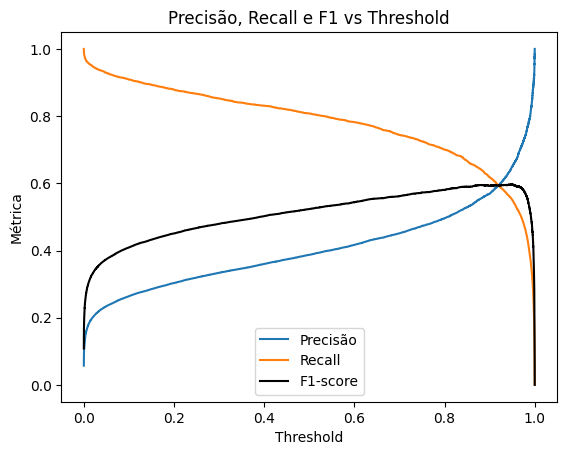

In [ ]:
# n_estimators: 2200
# max_depth: 6
# learning_rate: 0.09956713728310086
# min_child_weight: 3
# subsample: 0.7225306264485184
# colsample_bytree: 0.968908008504425
# reg_alpha: 0.004550157672283642
# reg_lambda: 0.7196738067104064
# scale_pos_weight: 16.37592695353882

model = XGBClassifier(
    learning_rate=0.09956713728310086,
    n_estimators=2200,
    max_depth=6,
    eval_metric='logloss',
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    subsample=0.7225306264485184,
    colsample_bytree= 0.968908008504425,
    reg_alpha= 0.004550157672283642,
    reg_lambda= 0.7196738067104064,
    scale_pos_weight= 16.37592695353882
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
    sample_weight=w_train,
)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

ModelMetrics.print_main_metrics(y_test, y_pred, y_pred_proba)
ModelMetrics.plot_precision_recall_curve(y_test, y_pred_proba)

In [ ]:
# Salvar modelo
with open('./model/xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
    

# Alternativa 3: RandomizedSearchCV

In [ ]:

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# ratio de classes para ponto de partida
pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

param_distributions = {
  'n_estimators': [600, 800, 1000, 1200, 1500, 1800, 2200],
  'max_depth': [3, 4, 5, 6],
  'learning_rate': [0.02, 0.03, 0.05, 0.08, 0.1],
  'min_child_weight': [1, 3, 5, 7],
  'subsample': [0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
  'reg_alpha': [0, 0.001, 0.01, 0.1],
  'reg_lambda': [0.5, 1.0, 2.0, 5.0],
  # explore ao redor do ratio
  'scale_pos_weight': [0.5*pos_weight, pos_weight, 1.5*pos_weight, 2*pos_weight]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crie um objeto GridSearchCV, e demorar muito, usa o RandomizedSearchCV
grid_search = RandomizedSearchCV(
  model, 
  param_distributions, 
  cv=cv, 
  scoring='f1',
  n_iter=40,
  random_state=42,
  verbose=2,
  refit=False
)

grid_search.fit(X_train, y_train, sample_weight=w_train)

# resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# treino final com early stopping (sem vazamento no CV)
final_params = {
  **best_params,
  'eval_metric': 'aucpr',
  'random_state': 42,
  'n_jobs': -1
}

best_model = XGBClassifier(**final_params)

# Execute a busca em grade para encontrar a melhor combinação de hiperparâmetros
grid_search.fit(
  X_train, 
  y_train,  
  eval_set=[(X_test, y_test)],
  early_stopping_rounds=200,
  verbose=100,
  sample_weight=w_train
)



## 6. Predictions

In [ ]:
y_pred = best_model.predict(X_test)
n=30
print(f"Primeiras {n} previsões:")
print(f"Classe prevista: {y_pred[:n]}")
print(f"Classe real: {y_test[:n].values}")

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

ModelMetrics.print_main_metrics(y_test, y_pred, y_pred_proba)

ModelMetrics.plot_precision_recall_curve(y_test, y_pred_proba)

ModelMetrics.plot_importance(model)

# Salvar

In [22]:

# Salvar modelo
with open('./model/xgboost_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Salvar também as features para uso futuro
with open('./model/model_features.pkl', 'wb') as f:
    pickle.dump(list(features.columns), f)

print("Modelo salvo como 'xgboost_model.pkl'")
print("Features salvas como 'model_features.pkl'")

Modelo salvo como 'xgboost_model.pkl'
Features salvas como 'model_features.pkl'
